# 量化交易策略開發實戰：從零到一

在本筆記本中，我們將遵循一個標準的量化研究流程，從數據準備、策略構思、回測到績效評估，完整地走過一遍。我們將使用台指期貨(TXF1)的分鐘級歷史數據，並實作一個經典的均線交叉策略作為範例。

**流程概覽：**
1. **環境準備 (Environment Setup):** 載入所有必要的 Python 函式庫。
2. **數據準備 (Data Preparation):** 讀取並清理台指期分鐘線數據。
3. **策略開發 (Strategy Development):** 建立一個簡單的移動平均線 (Moving Average) 交叉策略。
4. **回測執行 (Backtesting):** 根據策略產生的訊號，模擬交易過程。
5. **績效評估 (Performance Measurement):** 計算並分析策略的表現。
6. **檢討與展望 (Review and Outlook):** 討論策略的潛在問題與未來的優化方向。


## 步驟一：環境準備

首先，我們需要安裝並匯入這次實作所需要的函式庫，包含 `pandas` 用於數據處理、`numpy` 用於數值計算，以及 `matplotlib` 用於數據可視化。


In [1]:
# It is recommended to run this cell to install the required libraries
%pip install pandas numpy matplotlib seaborn

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 2.8 MB/s eta 0:00:03
   ----- ---------------------------------- 1.0/8.1 MB 2.8 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/8.1 MB 2.9 MB/s eta 0:00:03
   ----------- ---------------------------- 2.4/8.1 MB 2.9 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 2.9 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 3.0 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 3.1 MB/s eta 0:00:02
   ------------------------ --------------- 5.0/8.1 MB 3.1 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 3.1 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 3.2 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.1 MB 3.2 MB/s eta 0:00:01
   ---------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 6)

print("Environment setup completed successfully!")


Environment setup completed successfully!


## 步驟二：數據準備

接下來，我們要讀取位於 `data/` 資料夾中的 `TXF1_Minute_2020-01-01_2025-06-16.txt` 檔案。這個檔案包含了台指期的分鐘線數據。我們需要：

1. 檢查數據格式和內容
2. 將 `Date` 和 `Time` 兩個欄位合併成一個 `datetime` 物件
3. 將這個 `datetime` 欄位設定為 DataFrame 的索引 (Index)
4. 清理和重新命名欄位
5. 由於分鐘線數據噪音較大，且為了加快回測速度，我們將其**重採樣 (resample)** 成日線數據來進行初步的策略開發


In [3]:
# Load the data and examine its structure
file_path = './data/TXF1_Minute_2020-01-01_2025-06-16.txt'

try:
    # First, let's peek at the file to understand its structure
    with open(file_path, 'r', encoding='utf-8') as f:
        first_few_lines = [f.readline().strip() for _ in range(5)]
    
    print("First 5 lines of the file:")
    for i, line in enumerate(first_few_lines):
        print(f"Line {i+1}: {line}")
        
except FileNotFoundError:
    print(f"File not found: {file_path}")
    print("Please make sure the data file exists in the correct location.")


First 5 lines of the file:
Line 1: "Date","Time","Open","High","Low","Close","TotalVolume"
Line 2: 2019/12/31,15:01:00,11996.000000,11997.000000,11994.000000,11996.000000,147
Line 3: 2019/12/31,15:02:00,11996.000000,11996.000000,11992.000000,11993.000000,138
Line 4: 2019/12/31,15:03:00,11993.000000,11994.000000,11993.000000,11993.000000,73
Line 5: 2019/12/31,15:04:00,11993.000000,11995.000000,11993.000000,11994.000000,42


In [4]:
# Load the complete dataset
try:
    # Read the CSV file
    df = pd.read_csv(file_path, encoding='utf-8')
    
    print(f"Data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    print(df.head())
    print("\nData types:")
    print(df.dtypes)
    
except Exception as e:
    print(f"Error loading data: {e}")
    # If UTF-8 fails, try other encodings
    try:
        df = pd.read_csv(file_path, encoding='big5')
        print("Successfully loaded with Big5 encoding")
        print(f"Data shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print("\nFirst few rows:")
        print(df.head())
    except Exception as e2:
        print(f"Error with Big5 encoding: {e2}")
        # Try without specifying encoding
        try:
            df = pd.read_csv(file_path)
            print("Successfully loaded with default encoding")
            print(f"Data shape: {df.shape}")
            print(f"Columns: {list(df.columns)}")
            print("\nFirst few rows:")
            print(df.head())
        except Exception as e3:
            print(f"Final error: {e3}")


Data shape: (1495837, 7)
Columns: ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TotalVolume']

First few rows:
         Date      Time     Open     High      Low    Close  TotalVolume
0  2019/12/31  15:01:00  11996.0  11997.0  11994.0  11996.0          147
1  2019/12/31  15:02:00  11996.0  11996.0  11992.0  11993.0          138
2  2019/12/31  15:03:00  11993.0  11994.0  11993.0  11993.0           73
3  2019/12/31  15:04:00  11993.0  11995.0  11993.0  11994.0           42
4  2019/12/31  15:05:00  11994.0  11995.0  11994.0  11995.0           16

Data types:
Date            object
Time            object
Open           float64
High           float64
Low            float64
Close          float64
TotalVolume      int64
dtype: object


In [5]:
# Data preprocessing and cleaning
if 'df' in locals():
    # Create a copy for processing
    df_processed = df.copy()
    
    # Combine Date and Time columns if they exist separately
    if 'Date' in df_processed.columns and 'Time' in df_processed.columns:
        df_processed['datetime'] = pd.to_datetime(df_processed['Date'] + ' ' + df_processed['Time'])
    elif 'Date' in df_processed.columns:
        df_processed['datetime'] = pd.to_datetime(df_processed['Date'])
    else:
        # If datetime column already exists or needs to be created differently
        datetime_cols = [col for col in df_processed.columns if 'date' in col.lower() or 'time' in col.lower()]
        if datetime_cols:
            print(f"Found datetime-related columns: {datetime_cols}")
            # Use the first datetime column found
            df_processed['datetime'] = pd.to_datetime(df_processed[datetime_cols[0]])
    
    # Set datetime as index
    if 'datetime' in df_processed.columns:
        df_processed.set_index('datetime', inplace=True)
        df_processed.sort_index(inplace=True)
    
    # Identify OHLCV columns (Open, High, Low, Close, Volume)
    # Look for common column name patterns
    ohlcv_mapping = {}
    
    for col in df_processed.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['open', '開盤', '開']):
            ohlcv_mapping['Open'] = col
        elif any(keyword in col_lower for keyword in ['high', '最高', '高']):
            ohlcv_mapping['High'] = col
        elif any(keyword in col_lower for keyword in ['low', '最低', '低']):
            ohlcv_mapping['Low'] = col
        elif any(keyword in col_lower for keyword in ['close', '收盤', '收']):
            ohlcv_mapping['Close'] = col
        elif any(keyword in col_lower for keyword in ['volume', '成交量', '量']):
            ohlcv_mapping['Volume'] = col
    
    print(f"OHLCV column mapping: {ohlcv_mapping}")
    
    # Rename columns to standard names
    df_processed.rename(columns=ohlcv_mapping, inplace=True)
    
    # Select only OHLCV columns if they exist
    available_cols = [col for col in ['Open', 'High', 'Low', 'Close', 'Volume'] if col in df_processed.columns]
    if available_cols:
        df_processed = df_processed[available_cols]
    
    print(f"Processed data shape: {df_processed.shape}")
    print(f"Date range: {df_processed.index.min()} to {df_processed.index.max()}")
    print("\nProcessed data sample:")
    print(df_processed.head())
else:
    print("Data not loaded successfully. Please check the file path and format.")


OHLCV column mapping: {'Open': 'Open', 'High': 'High', 'Low': 'Low', 'Close': 'Close', 'Volume': 'TotalVolume'}
Processed data shape: (1495837, 4)
Date range: 2019-12-31 15:01:00 to 2025-06-16 13:45:00

Processed data sample:
                        Open     High      Low    Close
datetime                                               
2019-12-31 15:01:00  11996.0  11997.0  11994.0  11996.0
2019-12-31 15:02:00  11996.0  11996.0  11992.0  11993.0
2019-12-31 15:03:00  11993.0  11994.0  11993.0  11993.0
2019-12-31 15:04:00  11993.0  11995.0  11993.0  11994.0
2019-12-31 15:05:00  11994.0  11995.0  11994.0  11995.0


Daily data shape: (1615, 4)
Daily data date range: 2019-12-31 00:00:00 to 2025-06-16 00:00:00

Daily data sample:
               Open     High      Low    Close
datetime                                      
2019-12-31  11996.0  12013.0  11965.0  11997.0
2020-01-01  11997.0  12024.0  11988.0  12024.0
2020-01-02  12044.0  12163.0  12023.0  12154.0
2020-01-03  12155.0  12198.0  11996.0  12070.0
2020-01-04  12070.0  12084.0  12035.0  12043.0
2020-01-06  12017.0  12034.0  11901.0  11951.0
2020-01-07  11952.0  12009.0  11816.0  11896.0
2020-01-08  11896.0  11911.0  11697.0  11858.0
2020-01-09  11858.0  12005.0  11855.0  11987.0
2020-01-10  11987.0  12042.0  11940.0  12018.0


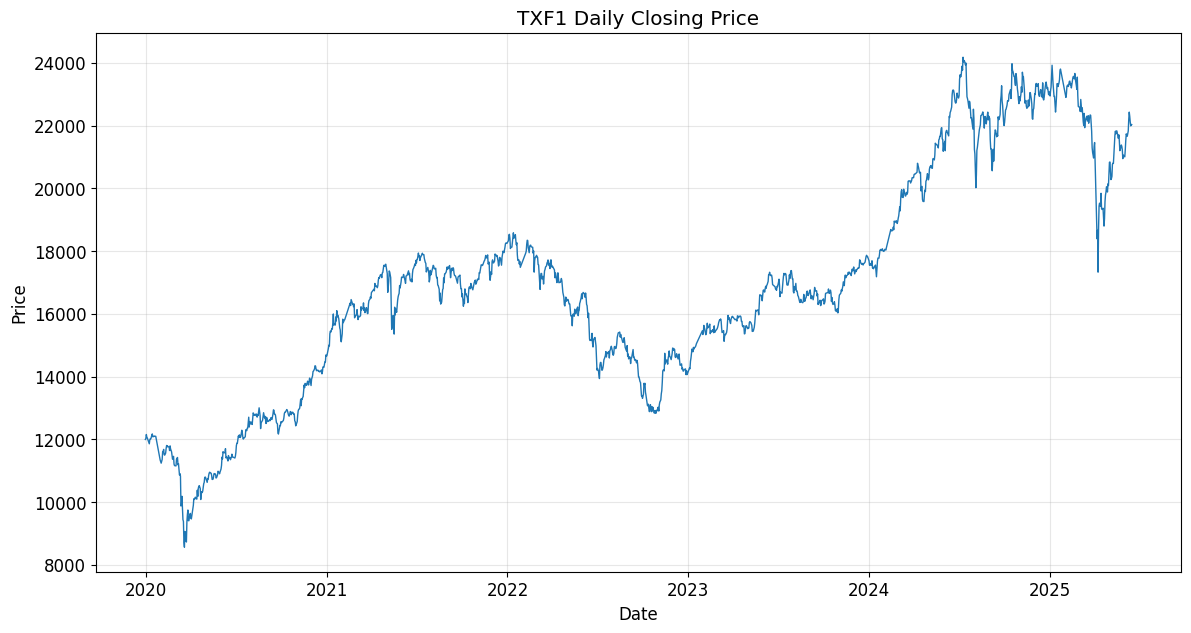

In [6]:
# Resample minute data to daily data for strategy development
if 'df_processed' in locals() and not df_processed.empty:
    # Resample to daily OHLCV data
    daily_agg = {
        'Open': 'first',    # First price of the day
        'High': 'max',      # Highest price of the day
        'Low': 'min',       # Lowest price of the day
        'Close': 'last',    # Last price of the day
        'Volume': 'sum'     # Total volume of the day
    }
    
    # Only include columns that exist in the data
    agg_dict = {col: daily_agg[col] for col in daily_agg if col in df_processed.columns}
    
    # Resample to daily frequency
    daily_df = df_processed.resample('D').agg(agg_dict)
    
    # Remove rows with NaN values (weekends and holidays)
    daily_df.dropna(inplace=True)
    
    print(f"Daily data shape: {daily_df.shape}")
    print(f"Daily data date range: {daily_df.index.min()} to {daily_df.index.max()}")
    print("\nDaily data sample:")
    print(daily_df.head(10))
    
    # Plot the closing price to visualize the data
    if 'Close' in daily_df.columns:
        plt.figure(figsize=(14, 7))
        plt.plot(daily_df.index, daily_df['Close'], linewidth=1)
        plt.title('TXF1 Daily Closing Price')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True, alpha=0.3)
        plt.show()
    
else:
    print("No processed data available for resampling.")


## 步驟三：策略開發

我們來定義一個簡單的**雙移動平均線交叉策略**：

- **短期均線 (Fast MA):** 反應近期的價格變化，較為敏感
- **長期均線 (Slow MA):** 反應長期的價格趨勢，較為平滑

**交易邏輯：**
- **買入訊號 (Long Signal):** 當短期均線由下往上穿越長期均線時（黃金交叉），視為市場可能進入上升趨勢，產生買入訊號
- **賣出訊號 (Short Signal):** 當短期均線由上往下穿越長期均線時（死亡交叉），視為市場可能進入下降趨勢，產生賣出訊號

這是一個經典的趨勢跟隨策略，適合在有明確趨勢的市場中使用。


In [7]:
# Define moving average crossover strategy
if 'daily_df' in locals() and 'Close' in daily_df.columns:
    # Strategy parameters
    fast_ma_window = 20  # Short-term moving average
    slow_ma_window = 60  # Long-term moving average
    
    # Create a copy for strategy development
    strategy_df = daily_df.copy()
    
    # Calculate moving averages
    strategy_df['MA_Fast'] = strategy_df['Close'].rolling(window=fast_ma_window).mean()
    strategy_df['MA_Slow'] = strategy_df['Close'].rolling(window=slow_ma_window).mean()
    
    # Drop rows with NaN values created by rolling function
    strategy_df.dropna(inplace=True)
    
    print(f"Strategy data shape after calculating MAs: {strategy_df.shape}")
    print(f"Strategy data date range: {strategy_df.index.min()} to {strategy_df.index.max()}")
    
    # Display the first few rows with moving averages
    print("\nData with moving averages:")
    print(strategy_df[['Close', 'MA_Fast', 'MA_Slow']].head(10))
    
else:
    print("Daily data not available for strategy development.")


Strategy data shape after calculating MAs: (1556, 6)
Strategy data date range: 2020-03-18 00:00:00 to 2025-06-16 00:00:00

Data with moving averages:
             Close   MA_Fast       MA_Slow
datetime                                  
2020-03-18  8714.0  10724.05  11450.333333
2020-03-19  8562.0  10583.80  11393.083333
2020-03-20  9065.0  10465.55  11343.766667
2020-03-21  8910.0  10338.15  11289.700000
2020-03-23  8728.0  10213.95  11234.000000
2020-03-24  9368.0  10124.25  11189.416667
2020-03-25  9598.0  10046.45  11150.200000
2020-03-26  9748.0   9965.50  11114.400000
2020-03-27  9409.0   9866.15  11073.583333
2020-03-28  9406.0   9765.35  11030.566667


In [8]:
# Generate trading signals
if 'strategy_df' in locals():
    # Initialize signal column
    strategy_df['Signal'] = 0
    strategy_df['Position'] = 0  # Track current position
    
    # Calculate crossover signals
    # Golden Cross: Fast MA crosses above Slow MA (Buy signal)
    # Death Cross: Fast MA crosses below Slow MA (Sell signal)
    
    for i in range(1, len(strategy_df)):
        current_fast = strategy_df['MA_Fast'].iloc[i]
        current_slow = strategy_df['MA_Slow'].iloc[i]
        prev_fast = strategy_df['MA_Fast'].iloc[i-1]
        prev_slow = strategy_df['MA_Slow'].iloc[i-1]
        
        # Golden Cross: Fast MA crosses above Slow MA
        if current_fast > current_slow and prev_fast <= prev_slow:
            strategy_df['Signal'].iloc[i] = 1  # Buy signal
        
        # Death Cross: Fast MA crosses below Slow MA
        elif current_fast < current_slow and prev_fast >= prev_slow:
            strategy_df['Signal'].iloc[i] = -1  # Sell signal
    
    # Count signals
    buy_signals = (strategy_df['Signal'] == 1).sum()
    sell_signals = (strategy_df['Signal'] == -1).sum()
    
    print(f"Total buy signals (Golden Cross): {buy_signals}")
    print(f"Total sell signals (Death Cross): {sell_signals}")
    
    # Display signal dates
    print("\nBuy signals (first 10):")
    buy_dates = strategy_df[strategy_df['Signal'] == 1].index[:10]
    for date in buy_dates:
        price = strategy_df.loc[date, 'Close']
        print(f"  {date.date()}: Close = {price:.2f}")
    
    print("\nSell signals (first 10):")
    sell_dates = strategy_df[strategy_df['Signal'] == -1].index[:10]
    for date in sell_dates:
        price = strategy_df.loc[date, 'Close']
        print(f"  {date.date()}: Close = {price:.2f}")
        
else:
    print("Strategy data not available for signal generation.")


Total buy signals (Golden Cross): 13
Total sell signals (Death Cross): 12

Buy signals (first 10):
  2020-04-30: Close = 10800.00
  2020-10-21: Close = 12787.00
  2021-06-12: Close = 17224.00
  2021-09-15: Close = 17291.00
  2021-11-09: Close = 17564.00
  2022-08-16: Close = 15420.00
  2022-11-19: Close = 14533.00
  2023-01-14: Close = 14920.00
  2023-05-22: Close = 16125.00
  2023-11-15: Close = 17235.00

Sell signals (first 10):
  2020-09-26: Close = 12267.00
  2021-05-21: Close = 16127.00
  2021-08-09: Close = 17454.00
  2021-10-02: Close = 16638.00
  2022-02-19: Close = 18129.00
  2022-09-14: Close = 14624.00
  2023-01-12: Close = 14932.00
  2023-05-09: Close = 15677.00
  2023-08-11: Close = 16580.00
  2024-08-05: Close = 20019.00


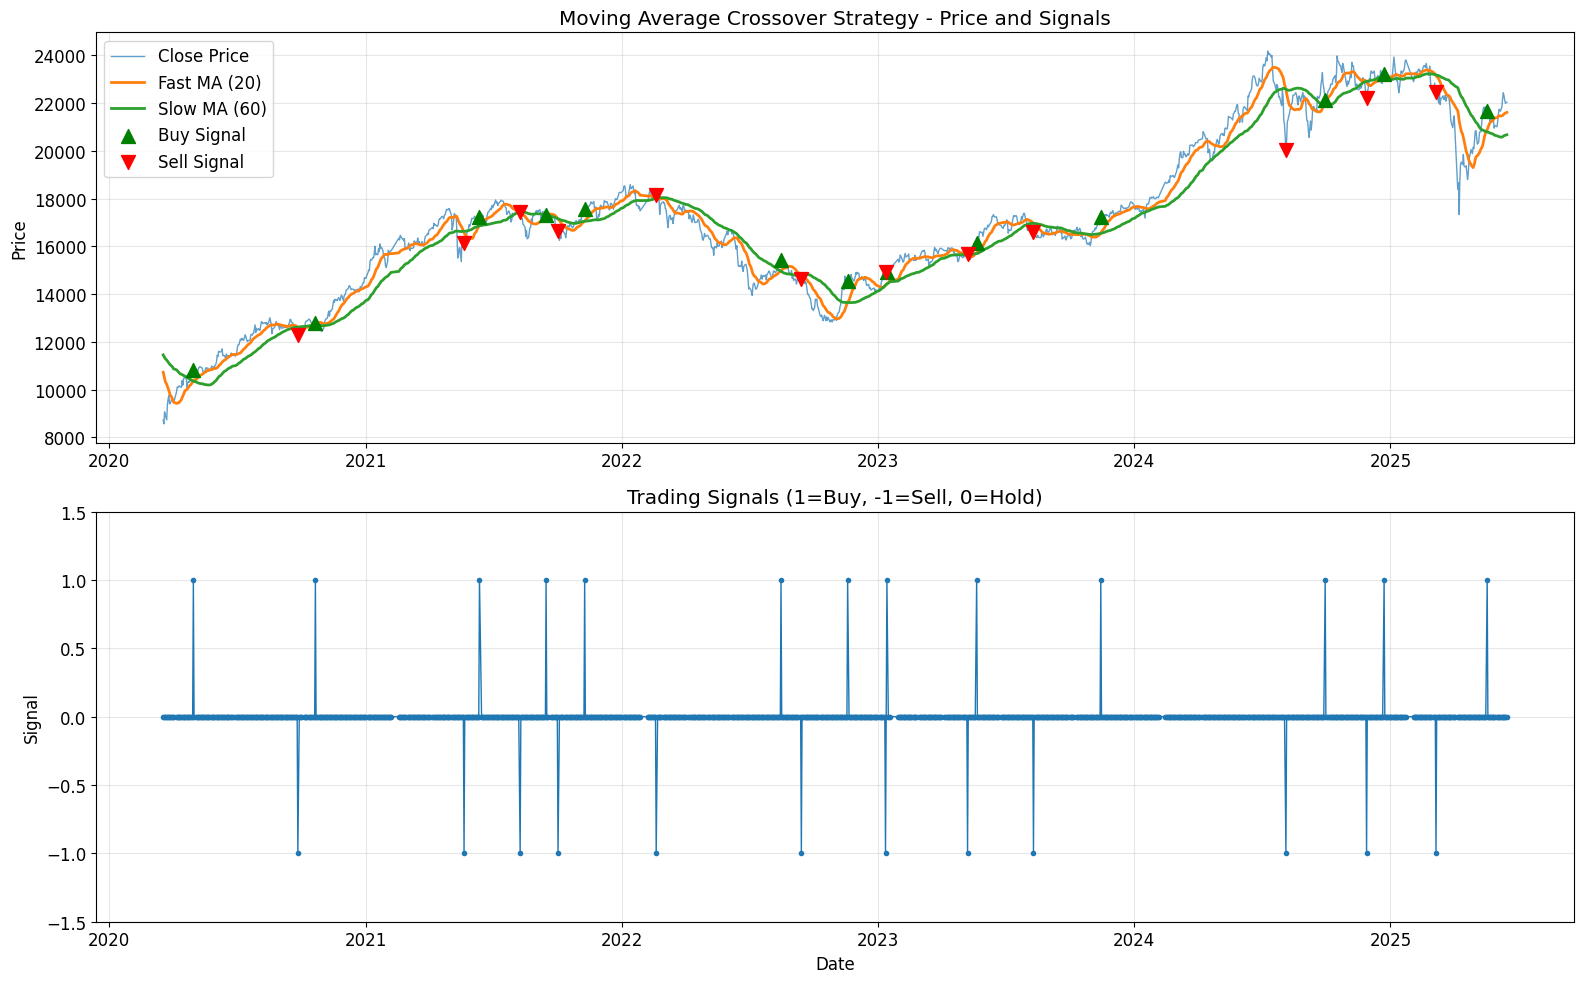

In [9]:
# Visualize the strategy signals
if 'strategy_df' in locals():
    plt.figure(figsize=(16, 10))
    
    # Plot closing price and moving averages
    plt.subplot(2, 1, 1)
    plt.plot(strategy_df.index, strategy_df['Close'], label='Close Price', alpha=0.7, linewidth=1)
    plt.plot(strategy_df.index, strategy_df['MA_Fast'], label=f'Fast MA ({fast_ma_window})', linewidth=2)
    plt.plot(strategy_df.index, strategy_df['MA_Slow'], label=f'Slow MA ({slow_ma_window})', linewidth=2)
    
    # Plot buy signals
    buy_signals_data = strategy_df[strategy_df['Signal'] == 1]
    if not buy_signals_data.empty:
        plt.scatter(buy_signals_data.index, buy_signals_data['Close'], 
                   color='green', marker='^', s=100, label='Buy Signal', zorder=5)
    
    # Plot sell signals
    sell_signals_data = strategy_df[strategy_df['Signal'] == -1]
    if not sell_signals_data.empty:
        plt.scatter(sell_signals_data.index, sell_signals_data['Close'], 
                   color='red', marker='v', s=100, label='Sell Signal', zorder=5)
    
    plt.title('Moving Average Crossover Strategy - Price and Signals')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot signals separately for clarity
    plt.subplot(2, 1, 2)
    plt.plot(strategy_df.index, strategy_df['Signal'], 'o-', markersize=3, linewidth=1)
    plt.title('Trading Signals (1=Buy, -1=Sell, 0=Hold)')
    plt.ylabel('Signal')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.ylim(-1.5, 1.5)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Strategy data not available for visualization.")


In [10]:
# Simple backtesting implementation
if 'strategy_df' in locals():
    # Backtesting parameters
    initial_capital = 1_000_000
    cash = initial_capital
    position = 0  # Number of units held
    entry_price = 0
    
    # Track portfolio value over time
    portfolio_values = []
    trades = []  # Record all trades
    
    # Backtest loop
    for i, (date, row) in enumerate(strategy_df.iterrows()):
        current_price = row['Close']
        signal = row['Signal']
        
        # Calculate current portfolio value
        if position > 0:
            portfolio_value = cash + (current_price - entry_price) * position
        else:
            portfolio_value = cash
        
        portfolio_values.append(portfolio_value)
        
        # Execute trades based on signals
        if signal == 1 and position == 0:
            # Buy signal
            position = 1
            entry_price = current_price
            trades.append({
                'Date': date,
                'Action': 'BUY',
                'Price': current_price,
                'Portfolio_Value': portfolio_value
            })
            
        elif signal == -1 and position > 0:
            # Sell signal
            pnl = (current_price - entry_price) * position
            cash += pnl
            
            trades.append({
                'Date': date,
                'Action': 'SELL',
                'Price': current_price,
                'Entry_Price': entry_price,
                'PnL': pnl,
                'Portfolio_Value': cash
            })
            
            position = 0
            entry_price = 0
    
    # Add portfolio values to dataframe
    strategy_df['Portfolio_Value'] = portfolio_values
    
    # Results
    final_value = portfolio_values[-1]
    
    print(f"=== BACKTEST RESULTS ===")
    print(f"Initial Capital: ${initial_capital:,.2f}")
    print(f"Final Portfolio Value: ${final_value:,.2f}")
    print(f"Total Return: {((final_value / initial_capital) - 1) * 100:.2f}%")
    print(f"Total Number of Trades: {len(trades)}")
    
    # Display trades
    if trades:
        trades_df = pd.DataFrame(trades)
        print(f"\\nTrade History (first 10 trades):")
        print(trades_df.head(10))


=== BACKTEST RESULTS ===
Initial Capital: $1,000,000.00
Final Portfolio Value: $1,008,219.00
Total Return: 0.82%
Total Number of Trades: 25
\nTrade History (first 10 trades):
        Date Action    Price  Portfolio_Value  Entry_Price     PnL
0 2020-04-30    BUY  10800.0        1000000.0          NaN     NaN
1 2020-09-26   SELL  12267.0        1001467.0      10800.0  1467.0
2 2020-10-21    BUY  12787.0        1001467.0          NaN     NaN
3 2021-05-21   SELL  16127.0        1004807.0      12787.0  3340.0
4 2021-06-12    BUY  17224.0        1004807.0          NaN     NaN
5 2021-08-09   SELL  17454.0        1005037.0      17224.0   230.0
6 2021-09-15    BUY  17291.0        1005037.0          NaN     NaN
7 2021-10-02   SELL  16638.0        1004384.0      17291.0  -653.0
8 2021-11-09    BUY  17564.0        1004384.0          NaN     NaN
9 2022-02-19   SELL  18129.0        1004949.0      17564.0   565.0


## 步驟五：績效評估

回測完成後，我們需要量化地評估策略的表現。常見的績效指標包含：

- **總回報率 (Total Return):** 策略期間的總體回報率
- **年化回報率 (Annualized Return):** 將總回報率轉換為年化數據
- **夏普比率 (Sharpe Ratio):** 衡量每單位風險所能換取的超額回報
- **最大回撤 (Maximum Drawdown):** 衡量策略從最高點回落到最低點的最大幅度
- **勝率 (Win Rate):** 獲利交易佔總交易數的比例

我們也會將資金曲線 (Equity Curve) 繪製出來，直觀地觀察策略價值的變化過程。


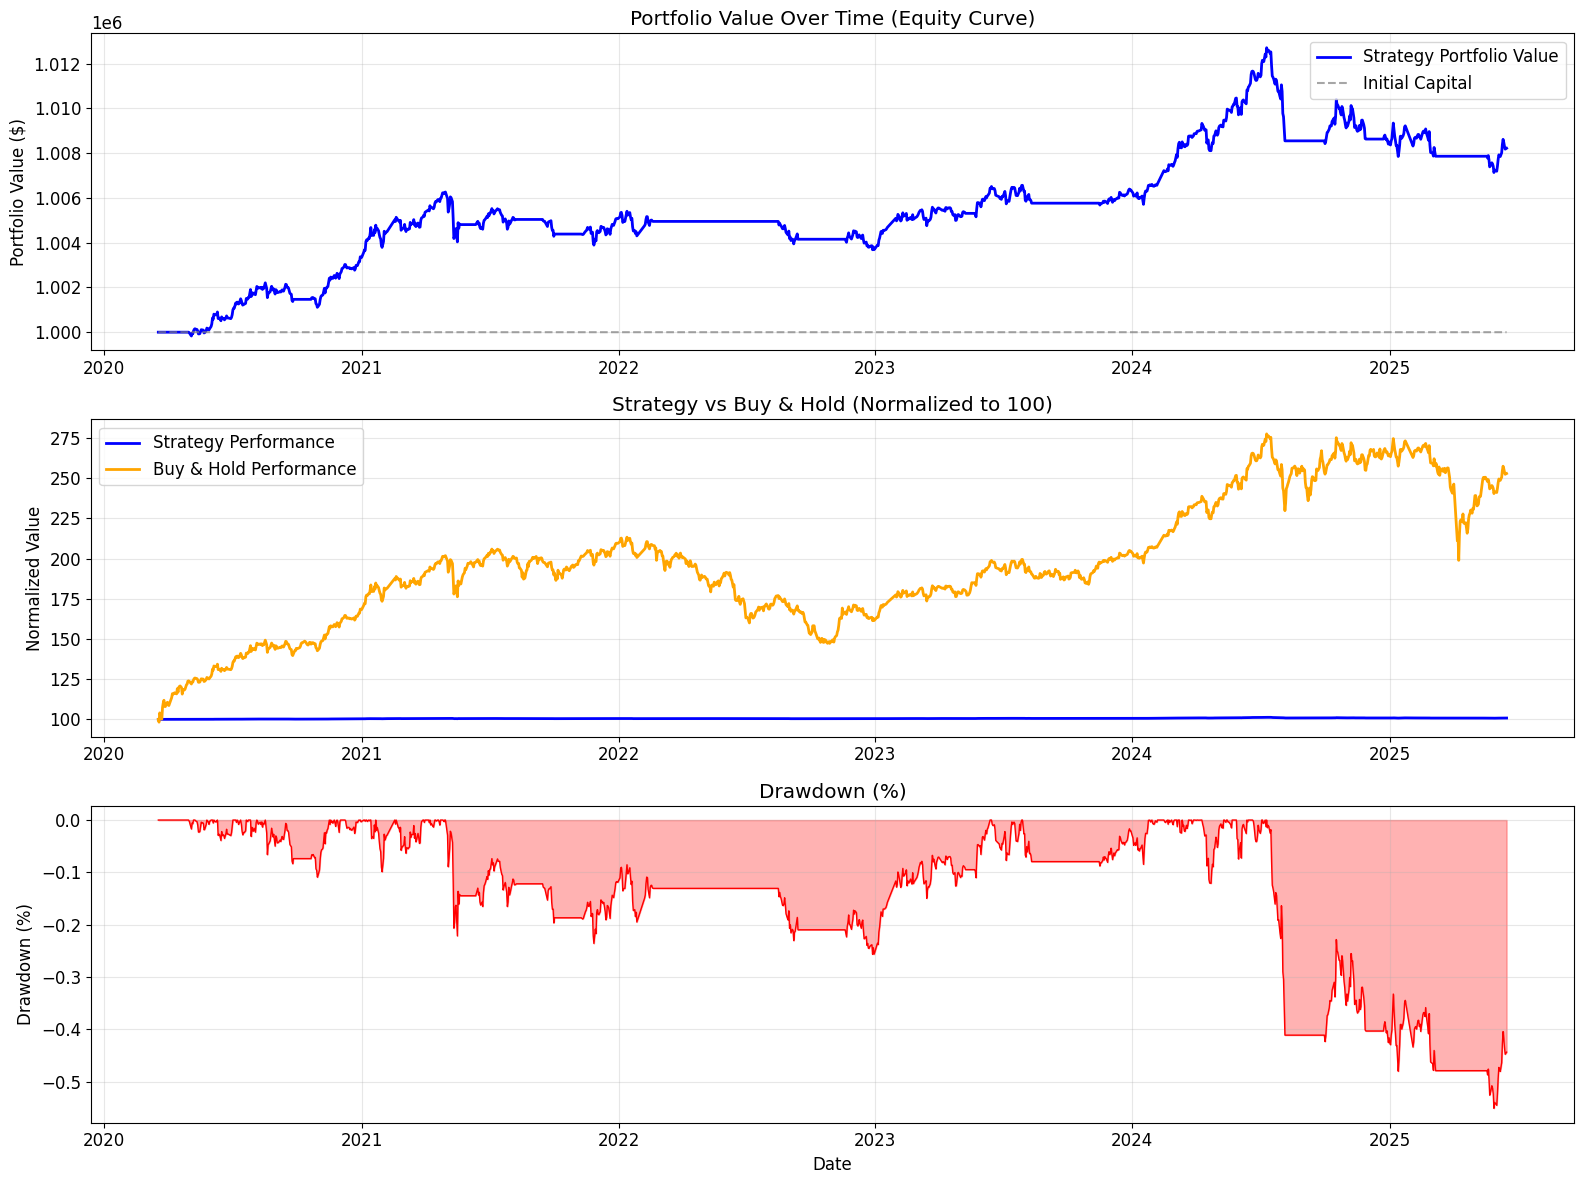

In [11]:
# Performance Analysis
if 'strategy_df' in locals() and 'trades_df' in locals():
    
    # 1. Plot Equity Curve
    plt.figure(figsize=(16, 12))
    
    # Equity curve
    plt.subplot(3, 1, 1)
    plt.plot(strategy_df.index, strategy_df['Portfolio_Value'], 
             label='Strategy Portfolio Value', linewidth=2, color='blue')
    plt.plot(strategy_df.index, [initial_capital] * len(strategy_df), 
             '--', label='Initial Capital', color='gray', alpha=0.7)
    plt.title('Portfolio Value Over Time (Equity Curve)')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Price comparison
    plt.subplot(3, 1, 2)
    # Normalize both to start at 100 for comparison
    normalized_portfolio = (strategy_df['Portfolio_Value'] / initial_capital) * 100
    normalized_price = (strategy_df['Close'] / strategy_df['Close'].iloc[0]) * 100
    
    plt.plot(strategy_df.index, normalized_portfolio, 
             label='Strategy Performance', linewidth=2, color='blue')
    plt.plot(strategy_df.index, normalized_price, 
             label='Buy & Hold Performance', linewidth=2, color='orange')
    plt.title('Strategy vs Buy & Hold (Normalized to 100)')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Drawdown
    plt.subplot(3, 1, 3)
    rolling_max = strategy_df['Portfolio_Value'].cummax()
    drawdown = (strategy_df['Portfolio_Value'] - rolling_max) / rolling_max * 100
    plt.fill_between(strategy_df.index, drawdown, 0, alpha=0.3, color='red')
    plt.plot(strategy_df.index, drawdown, color='red', linewidth=1)
    plt.title('Drawdown (%)')
    plt.ylabel('Drawdown (%)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Performance analysis data not available.")


## 步驟六：檢討與展望

恭喜！我們已經完成了一次完整的策略回測。但這僅僅是個開始，一個「玩具」範例。在將策略投入實戰前，我們必須清醒地認識到其局限性：

### 🚨 常見陷阱與限制

1. **過度擬合 (Overfitting):** 我們選擇的 `20/60` 均線參數可能只是恰好在這段歷史數據上表現良好。它在未來是否依然有效？需要進行樣本外測試 (Out-of-Sample Testing) 來驗證。

2. **交易成本被忽略 (Transaction Costs):** 我們的回測沒有包含手續費和滑價。對於交易頻繁的策略，這兩項成本會嚴重侵蝕獲利。

3. **模型過於簡化 (Oversimplified Model):** 
   - 我們只在收盤價進行判斷和交易，忽略了盤中的價格波動
   - 沒有考慮放空操作，錯失了下跌行情中的獲利機會
   - 倉位管理過於簡單，永遠是「全進全出」

4. **未來函數 (Look-ahead Bias):** 雖然我們在這個範例中避免了這個問題，但在更複雜的策略中需要特別小心。

### 🔮 未來可以探索的方向

- **參數優化與穩健性測試:** 測試不同的均線參數組合，觀察績效是否穩健
- **引入停損停利:** 為每筆交易設定停損點和停利點，控制風險
- **多時間框架分析:** 結合不同時間週期的訊號
- **加入成交量分析:** 「價漲量增」和「價漲量縮」是否代表不同意義？
- **使用更專業的回測框架:** 將我們的策略邏輯改用 `backtesting.py` 或 `VectorBT` 等專業函式庫來實現

### 💡 關鍵學習重點

通過這次實作，我們學會了：
- 如何處理和清理金融時間序列數據
- 如何實現簡單的技術分析策略
- 如何進行基礎的回測和績效評估
- 如何識別策略開發中的常見陷阱

記住：**量化交易是科學與藝術的結合**。數據和邏輯是基礎，但市場的複雜性永遠超出我們的想像。保持謙遜，持續學習，才是長期成功的關鍵。


In [12]:
# Calculate performance metrics
if 'strategy_df' in locals() and 'trades_df' in locals():
    
    # Basic metrics
    total_return = (final_value / initial_capital) - 1
    trading_days = len(strategy_df)
    years = trading_days / 252
    annualized_return = (final_value / initial_capital) ** (1/years) - 1
    
    # Risk metrics
    daily_returns = strategy_df['Portfolio_Value'].pct_change().dropna()
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() != 0 else 0
    
    # Maximum Drawdown
    rolling_max = strategy_df['Portfolio_Value'].cummax()
    drawdown = (strategy_df['Portfolio_Value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Trade analysis
    sell_trades = trades_df[trades_df['Action'] == 'SELL'].copy()
    if not sell_trades.empty:
        winning_trades = sell_trades[sell_trades['PnL'] > 0]
        win_rate = len(winning_trades) / len(sell_trades)
        avg_win = winning_trades['PnL'].mean() if not winning_trades.empty else 0
        avg_loss = sell_trades[sell_trades['PnL'] < 0]['PnL'].mean() if len(sell_trades[sell_trades['PnL'] < 0]) > 0 else 0
    else:
        win_rate = avg_win = avg_loss = 0
    
    # Buy & Hold comparison
    buy_hold_return = (strategy_df['Close'].iloc[-1] / strategy_df['Close'].iloc[0]) - 1
    
    # Print results
    print("="*50)
    print("     PERFORMANCE REPORT")
    print("="*50)
    print(f"Initial Capital:      ${initial_capital:,.2f}")
    print(f"Final Value:          ${final_value:,.2f}")
    print(f"Total Return:         {total_return:.2%}")
    print(f"Annualized Return:    {annualized_return:.2%}")
    print(f"Sharpe Ratio:         {sharpe_ratio:.2f}")
    print(f"Max Drawdown:         {max_drawdown:.2%}")
    print(f"Win Rate:             {win_rate:.2%}")
    print(f"Buy & Hold Return:    {buy_hold_return:.2%}")
    print(f"Outperformance:       {(total_return - buy_hold_return):.2%}")
    print("="*50)


     PERFORMANCE REPORT
Initial Capital:      $1,000,000.00
Final Value:          $1,008,219.00
Total Return:         0.82%
Annualized Return:    0.13%
Sharpe Ratio:         0.59
Max Drawdown:         -0.55%
Win Rate:             75.00%
Buy & Hold Return:    152.83%
Outperformance:       -152.01%


## 步驟四：簡易回測

現在我們有了交易訊號，接下來要模擬實際的交易過程。我們採用一個簡化的回測模型：

- **起始資金：** 假設為 1,000,000 元
- **交易單位：** 每次交易一個單位（簡化處理）
- **倉位管理：** 
  - 收到買入訊號 (`Signal = 1`) 且當前無倉位，則買入
  - 收到賣出訊號 (`Signal = -1`) 且當前持有多頭倉位，則賣出平倉
  - (為簡化起見，本範例**不考慮放空**)
- **忽略成本：** 暫時不考慮手續費和滑價

我們將逐日遍歷數據，根據訊號和倉位狀態來更新我們的投資組合價值 (Portfolio Value)。
